<a href="https://colab.research.google.com/github/pinkdolphin11/ESAA/blob/main/5_2_HW.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Chap 3. 평가**

머신러닝 프로세스 : 데이터 가공/변환, 모델 학습/예측, 평가(Evaluation)

분류의 성능 평가 지표
* 정확도(Accuracy)
* 오차행렬(Confusion Matrix)
* 정밀도(Precision)
* 재현율(Recall)
* F1 스코어
* ROC AUC

이진 분류 : 결정 클래스 값 종류의 유형에 따라 긍정/부정과 같은 2개의 결과값만을 갖는 분류

**01. 정확도(Accuracy)**

정확도 : 실제 데이터에서 예측 데이터가 얼마나 같은지 판단하는 지표

정확도 = 예측 결과가 동일한 데이터 건수/전체 예측 데이터 건수

사이킷런의 BaseEstimator 클래스를 상속받아 아무런 학습을 하지 않고, 성별에 따라 생존자를 예측하는 단순한 Classifier를 생성

In [1]:
import numpy as np

from sklearn.base import BaseEstimator

class MyDummyClassifier(BaseEstimator):
  #fit() 메서드는 아무것도 학습하지 않음
  def fit(self, X, y=None):
    pass
  #predict() 메서드는 단순히 Sex 피처가 1이면 0, 그렇지 않으면 1로 예측
  def predict(self, X):
    pred = np.zeros((X.shape[0],1))
    for i in range (X.shape[0]):
      if X['Sex'].iloc[i]==1:
        pred[i]=0
      else:
        pred[i]=1
    return pred

생성된 MyDummyClassifier를 이용해 타이타닉 생존자 예측을 수행

In [2]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

#원본 데이터 재로딩, 데이터 가공, 학습 데이터/테스트 데이터 분할

from google.colab import auth
auth.authenticate_user()
from google.colab import drive
drive.mount('/content/gdrive')
titanic_df=pd.read_csv('../content/gdrive/MyDrive/titanic_train.csv.csv')


from sklearn.preprocessing import LabelEncoder

def fillna(df):
  df['Age'].fillna(df['Age'].mean(),inplace=True)
  df['Cabin'].fillna('N',inplace=True)
  df['Embarked'].fillna('N',inplace=True)
  df['Fare'].fillna(0,inplace=True)
  return df

def drop_features(df):
  df.drop(['PassengerId','Name','Ticket'],axis=1,inplace=True)
  return df

def format_features(df):
  df['Cabin']=df['Cabin'].str[:1]
  features=['Cabin','Sex','Embarked']
  for feature in features:
    le=LabelEncoder()
    le=le.fit(df[feature])
    df[feature]=le.transform(df[feature])
  return df

def transform_features(df):
  df=fillna(df)
  df=drop_features(df)
  df=format_features(df)
  return df

y_titanic_df=titanic_df['Survived']
X_titanic_df=titanic_df.drop('Survived',axis=1)
X_titanic_df=transform_features(X_titanic_df)
X_train, X_test, y_train, y_test=train_test_split(X_titanic_df, y_titanic_df, test_size=0.2, random_state=0)

Mounted at /content/gdrive


In [3]:
#위에서 생성한 Dummy Classifier를 이용해 학습/예측/평가 수행

myclf=MyDummyClassifier()
myclf.fit(X_train,y_train)

mypredictions=myclf.predict(X_test)
print('Dummy Classifier의 정확도는: {0:.4f}'.format(accuracy_score(y_test, mypredictions)))

Dummy Classifier의 정확도는: 0.7877


정확도는 불균형한(imbalanced) 레이블 값 분포에서 ML 모델의 성능을 판단할 경우 적합한 평가 지표가 아니다. 예를 들어 100개의 데이터가 있고 이 중에 90개의 데이터 레이블이 0, 단 10개의 데이터 레이블이 1이라고 한다면 무조건 0으로 예측 결과를 반환하는 ML 모델의 경우라도 정확도가 90%가 된다.

In [4]:
from sklearn.datasets import load_digits

class MyFakeClassifier(BaseEstimator):
  def fit(self, X, y):
    pass

  #입력값으로 들어오는 X 데이터 세트의 크기만큼 모두 0값으로 만들어서 반환
  def predict(self, X):
    return np.zeros((len(X),1),dtype=bool)

#사이킷런의 내장 데이터 세트 load_digits()를 이용해 MNIST 데이터 로딩
digits=load_digits()

#digits 번호가 7번이면 True이고 이를 astype(int)로 1로 변환, 7번이 아니면 False이고 0으로 변환
y=(digits.target==7).astype(int)
X_train, X_test, y_train, y_test = train_test_split(digits.data, y, random_state=11)

In [5]:
#불균형한 레이블 데이터 분포도 확인
print('레이블 테스트 세트 크기:',y_test.shape)
print('테스트 세트 레이블 0과 1의 분포도')
print(pd.Series(y_test).value_counts())

#Dummy Classifier로 학습/예측/정확도 평가
fakeclf=MyFakeClassifier()
fakeclf.fit(X_train, y_train)
fakepred=fakeclf.predict(X_test)
print('모든 예측을 0으로 하여도 정확도는:{:.3f}'.format(accuracy_score(y_test,fakepred)))

레이블 테스트 세트 크기: (450,)
테스트 세트 레이블 0과 1의 분포도
0    405
1     45
dtype: int64
모든 예측을 0으로 하여도 정확도는:0.900


**02. 오차 행렬(confusion matrix)**

오차 행렬 : 이진 분류의 예측 오류가 얼마인지와 더불어 어떠한 유형의 예측 오류가 발생하고 있는지 함께 나타내는 지표. 학습된 분류 모델이 예측을 수행하면서 얼마나 헷갈리고(confused) 있는지 함께 보여주는 지표

4분면 행렬에서 실제 레이블 클래스 값과 예측 레이블 클래스 값이 어떠한 유형을 가지고 매핑되는지 나타낸다.

* TN : 예측값 Negative 0, 실제 값 Negative 0
* FP : 예측값 Positive 1, 실제 값 Negative 0
* FN : 예측값 Negative 0, 실제 값 Positive 0
* TP : 예측값 Positive 1, 실제 값 Positive 1

In [6]:
from sklearn.metrics import confusion_matrix

confusion_matrix(y_test, fakepred)

array([[405,   0],
       [ 45,   0]])

이 결과는 전체 450건 데이터 중 무조건 Negative 0으로 예측해서 True가 된 결과 405건, FP는 positive 1로 예측한 건수가 없으므로 0건, FN은 Positive 1인 건수 45건을 Negative로 예측해서 False가 된 결과 45건, TP는 positive 1로 예측한 건수가 없으므로 0건임을 보여준다.

오차 행렬상에서 정확도는 다음과 같이 정의한다.

정확도 = 예측 결과와 실제 값이 동일한 건수/전체 데이터 수 = (TN+TP)/(TN+FP+FN+TP)

일반적으로 불균형한 레이블 클래스를 가지는 이진 분류 모델에서는 많은 데이터 중에서 중점적으로 찾아야 하는 매우 적은 수의 결과값에 Positive를 설정해 1값을 부여하고, 그렇지 않은 경우 Negative로 0값을 부여하는 경우가 많다. 결과적으로 정확도 지표는 비대칭한 데이터 세트에서 Positive에 대한 예측 정확도를 판단하지 못한 채 Negative에 대한 예측 정확도만으로 분류의 정확도가 매우 높게 나타나는 수치적 판단 오류를 일으키게 된다.

**03. 정밀도와 재현율**

정밀도와 재현율은 Positive 데이터 세트의 예측 성능에 좀 더 초점을 맞춘 평가 지표이다.

정밀도 = TP/(FP+TP)

정밀도 : 예측을 Positive로 한 대상 중에 예측과 실제 값이 Positive로 일치한 데이터의 비율(양성 예측도)

재현율 = TP/(FN+TP)

재현율 : 실제 값이 Positive인 대상 중에 예측과 실제 값이 Positive로 일치한 데이터 건수(민감도, TPR)

재현율은 실제 Positive 양성 데이터를 Negative로 잘못 판단하게 되면 업무상 큰 영향이 발생하는 경우 중요한 지표로 간주된다.

ex> 암 판단 모델, 금융 사기 적발 모델 등

보통은 재현율이 더 중요하지만 정밀도가 더 중요한 지표인 경우도 있다.

ex> 스팸메일 여부 판단 모델

In [7]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, confusion_matrix

def get_clf_eval(y_test,pred):
  confusion=confusion_matrix(y_test,pred)
  accuracy=accuracy_score(y_test,pred)
  precision=precision_score(y_test,pred)
  recall=recall_score(y_test,pred)
  print('오차 행렬')
  print(confusion)
  print('정확도: {0:.4f}, 정밀도: {1:.4f}, 재현율: {2:.4f}'.format(accuracy, precision, recall))

In [8]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression

#원본 데이터 재로딩, 데이터 가공, 학습 데이터/테스트 데이터 분할
titanic_df=pd.read_csv('../content/gdrive/MyDrive/titanic_train.csv.csv')
y_titanic_df=titanic_df['Survived']
X_titanic_df=titanic_df.drop('Survived',axis=1)
X_titanic_df=transform_features(X_titanic_df)

X_train, X_test, y_train, y_test = train_test_split(X_titanic_df, y_titanic_df, test_size=0.20, random_state=11)

lr_clf=LogisticRegression()

lr_clf.fit(X_train,y_train)
pred=lr_clf.predict(X_test)
get_clf_eval(y_test,pred)

오차 행렬
[[104  14]
 [ 13  48]]
정확도: 0.8492, 정밀도: 0.7742, 재현율: 0.7869


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,


[정밀도/재현율 트레이드오프]

분류하려는 업무의 특성상 정밀도 또는 재현율이 특별히 강조돼야 할 경우 분류의 결정 임계값(Threshold)을 조정해 정밀도 또는 재현율의 수치를 높일 수 있다. 하지만 둘은 상호 보완적인 평가 지표이므로 어느 한쪽을 강제로 높이면 다른 하나의 수치는 떨어지기 쉽다.

In [9]:
pred_proba=lr_clf.predict_proba(X_test)
pred=lr_clf.predict(X_test)
print('pred_proba()결과 Shape : {0}'.format(pred_proba.shape))
print('pred_proba array에서 앞 3개만 샘플로 추출 \n:',pred_proba[:3])

#예측 확률 array와 예측 결과값 array를 병합(concatenate)해서 예측 확률과 결과값을 한눈에 확인
pred_proba_result=np.concatenate([pred_proba,pred.reshape(-1,1)],axis=1)
print('두 개의 class 중에서 더 큰 확률을 클래스 값으로 예측 \n',pred_proba_result[:3])

pred_proba()결과 Shape : (179, 2)
pred_proba array에서 앞 3개만 샘플로 추출 
: [[0.46191519 0.53808481]
 [0.878675   0.121325  ]
 [0.87716185 0.12283815]]
두 개의 class 중에서 더 큰 확률을 클래스 값으로 예측 
 [[0.46191519 0.53808481 1.        ]
 [0.878675   0.121325   0.        ]
 [0.87716185 0.12283815 0.        ]]


predict() 메서드는 predict_proba() 메서드에 기반해 생성된 API이다. predict()는 predict_proba() 호출 결과로 반환된 배열에서 분류 결정 임계값보다 큰 값이 들어 있는 칼럼의 위치를 받아서 최종적으로 예측 클래스를 결정하는 API이다. 분류 결정 임계값을 조절하는 로직을 직접 코드로 구현해 보자.

In [10]:
from sklearn.preprocessing import Binarizer

X=[[1,-1,2],[2,0,0],[0,1.1,1.2]]

#X의 개별 원소들이 threshol값보다 같거나 작으면 0을, 크면 1을 반환
binarizer=Binarizer(threshold=1.1)
print(binarizer.fit_transform(X))

[[0. 0. 1.]
 [1. 0. 0.]
 [0. 0. 1.]]


In [11]:
from sklearn.preprocessing import Binarizer

#Binarizer의 threshold 설정값. 분류 결정 임계값임.
custom_threshold=0.5

#predict_proba() 반환값의 두 번째 칼럼, 즉 Positive 클래스 칼럼 하나만 추출해 Binarizer를 적용
pred_proba_1=pred_proba[:,1].reshape(-1,1)

binarizer = Binarizer(threshold=custom_threshold).fit(pred_proba_1)
custom_predict=binarizer.transform(pred_proba_1)

get_clf_eval(y_test,custom_predict)

오차 행렬
[[104  14]
 [ 13  48]]
정확도: 0.8492, 정밀도: 0.7742, 재현율: 0.7869


In [12]:
#임계값을 낮춤
custom_threshold=0.4
pred_proba_1=pred_proba[:,1].reshape(-1,1)
binarizer=Binarizer(threshold=custom_threshold).fit(pred_proba_1)
custom_predict=binarizer.transform(pred_proba_1)

get_clf_eval(y_test,custom_predict)

오차 행렬
[[98 20]
 [10 51]]
정확도: 0.8324, 정밀도: 0.7183, 재현율: 0.8361


분류 결정 임계값은 Positive 예측값을 결정하는 확률의 기준이므로 임계값을 낮출수록 True 값이 많아져서 재현율이 높아진다.

In [13]:
#테스트를 수행할 모든 임계값을 리스트 객체로 저장
thresholds=[0.4,0.45,0.50,0.55,0.60]

def get_eval_by_threshold(y_test,pred_proba_c1,thresholds):
  #thresholds list객체 내의 값을 차례로 iteration하면서 Evaluation 수행
  for custom_threshold in thresholds:
    binarizer=Binarizer(threshold=custom_threshold).fit(pred_proba_c1)
    custom_predict=binarizer.transform(pred_proba_c1)
    print('임계값:',custom_threshold)
    get_clf_eval(y_test,custom_predict)
  
get_eval_by_threshold(y_test,pred_proba[:,1].reshape(-1,1),thresholds)

임계값: 0.4
오차 행렬
[[98 20]
 [10 51]]
정확도: 0.8324, 정밀도: 0.7183, 재현율: 0.8361
임계값: 0.45
오차 행렬
[[103  15]
 [ 12  49]]
정확도: 0.8492, 정밀도: 0.7656, 재현율: 0.8033
임계값: 0.5
오차 행렬
[[104  14]
 [ 13  48]]
정확도: 0.8492, 정밀도: 0.7742, 재현율: 0.7869
임계값: 0.55
오차 행렬
[[109   9]
 [ 15  46]]
정확도: 0.8659, 정밀도: 0.8364, 재현율: 0.7541
임계값: 0.6
오차 행렬
[[112   6]
 [ 16  45]]
정확도: 0.8771, 정밀도: 0.8824, 재현율: 0.7377


재현율을 향상시키면서 다른 수치를 어느 정도 감소하는 희생을 해야 한다면 임계값이 0.45인 경우가 적당하다.

precision_recall_curve()를 이용해 타이타닉 예측 모델의 임계값별 정밀도와 재현율을 구하자. 인자로 실제 값 데이터 세트와 레이블 값이 1일 때의 예측 확률 값을 입력한다.

In [14]:
from sklearn.metrics import precision_recall_curve

#레이블 값이 1일 때의 예측 확률을 추출
pred_proba_class1=lr_clf.predict_proba(X_test)[:,1]

#실제 값 데이터 세트와 레이블 값이 1일 때의 예측 확률을 precision_recall_curve 인자로 입력
precisions, recalls, thresholds = precision_recall_curve(y_test, pred_proba_class1)
print('반환된 분류 결정 임계값 배열의 Shape:',thresholds.shape)

#반환된 임계값 배열 로우가 147건이므로 샘플로 10건만 추출하되, 임계값을 15 Step으로 추출
thr_index=np.arange(0,thresholds.shape[0],15)
print('샘플 추출을 위한 임계값 배열의 index 10개:', thr_index)
print('샘플용 10개의 임계값:',np.round(thresholds[thr_index],2))

#15 step 단위로 추출된 임계값에 따른 정밀도와 재현율 값
print('샘플 임계값별 정밀도:', np.round(precisions[thr_index],3))
print('샘플 임계값별 재현율:', np.round(recalls[thr_index],3))

반환된 분류 결정 임계값 배열의 Shape: (143,)
샘플 추출을 위한 임계값 배열의 index 10개: [  0  15  30  45  60  75  90 105 120 135]
샘플용 10개의 임계값: [0.1  0.12 0.14 0.19 0.28 0.4  0.56 0.67 0.82 0.95]
샘플 임계값별 정밀도: [0.389 0.44  0.466 0.539 0.647 0.729 0.836 0.949 0.958 1.   ]
샘플 임계값별 재현율: [1.    0.967 0.902 0.902 0.902 0.836 0.754 0.607 0.377 0.148]


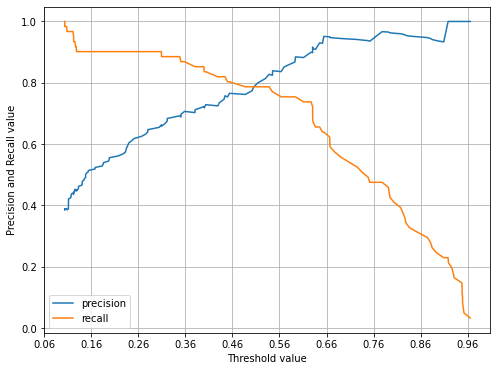

In [16]:
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
%matplotlib inline

def precision_recall_curve_plot(y_test, pred_proba_c1):
  #threshold ndarray와 이 threshold에 따른 정밀도, 재현율 ndarray 추출
  precisions, recalls, thresholds=precision_recall_curve(y_test,pred_proba_c1)

  #X축을 threshold 값으로, Y축은 정밀도, 재현율 값으로 각각 Plot 수행. 정밀도느 점선으로 표시
  plt.figure(figsize=(8,6))
  threshold_boundary=thresholds.shape[0]
  plt.plot(thresholds, precisions[0:threshold_boundary],linestyle='-',label='precision')
  plt.plot(thresholds, recalls[0:threshold_boundary],label='recall')

  #threshold 값 X축의 Scale을 0.1 단위로 변경
  start, end = plt.xlim()
  plt.xticks(np.round(np.arange(start,end,0.1),2))

  #X축, y축 label과 legend, 그리고 grid 설정
  plt.xlabel('Threshold value'); plt.ylabel('Precision and Recall value')
  plt.legend(); plt.grid()
  plt.show()

precision_recall_curve_plot(y_test, lr_clf.predict_proba(X_test)[:,1])

[정밀도와 재현율의 맹점]

<정밀도가 100%가 되는 방법>

확실한 기준이 되는 경우만 Positive로 예측하고 나머지는 모두 Negative로 예측

<재현율이 100%가 되는 방법>

모든 환자를 Positive로 예측

임계값의 변경은 업무 환경에 맞게 두 개의 수치를 상호 보완할 수 있는 수준에서 적용돼야 한다.

**04. F1 스코어**

F1 스코어(Score) : 정밀도와 재현율을 결합한 지표, 정밀도와 재현율이 어느 한쪽으로 치우치지 않는 수치를 나타낼 때 상대적으로 높은 값을 가진다.

F1 = 2 X (precision*recall)/(precision+recall)



In [17]:
from sklearn.metrics import f1_score
f1=f1_score(y_test,pred)
print('F1 스코어: {0:.4f}'.format(f1))

F1 스코어: 0.7805


In [19]:
def get_clf_eval(y_test,pred):
  confusion = confusion_matrix(y_test, pred)
  accuracy = accuracy_score(y_test, pred)
  precision = precision_score(y_test, pred)
  recall = recall_score(y_test, pred)
  #F1 스코어 추가
  f1=f1_score(y_test, pred)
  print('오차 행렬')
  print(confusion)
  #f1 score print 추가
  print('정확도: {0:.4f}, 정밀도: {1:.4f}, 재현율: {2:.4f}, F1:{3:.4f}'.format(accuracy, precision, recall, f1))

thresholds=[0.4,0.45,0.50,0.55,0.60]
pred_proba = lr_clf.predict_proba(X_test)
get_eval_by_threshold(y_test, pred_proba[:,1].reshape(-1,1), thresholds)

임계값: 0.4
오차 행렬
[[98 20]
 [10 51]]
정확도: 0.8324, 정밀도: 0.7183, 재현율: 0.8361, F1:0.7727
임계값: 0.45
오차 행렬
[[103  15]
 [ 12  49]]
정확도: 0.8492, 정밀도: 0.7656, 재현율: 0.8033, F1:0.7840
임계값: 0.5
오차 행렬
[[104  14]
 [ 13  48]]
정확도: 0.8492, 정밀도: 0.7742, 재현율: 0.7869, F1:0.7805
임계값: 0.55
오차 행렬
[[109   9]
 [ 15  46]]
정확도: 0.8659, 정밀도: 0.8364, 재현율: 0.7541, F1:0.7931
임계값: 0.6
오차 행렬
[[112   6]
 [ 16  45]]
정확도: 0.8771, 정밀도: 0.8824, 재현율: 0.7377, F1:0.8036


**05. ROC 곡선와 AUC**

ROC 곡선 : FPR(False Positive Rate)이 변할 때 TPR(True Positive Rate)이 어떻게 변하는지 나타내는 곡선

FPR = FP/(FP+TN) = 1-TNR = 1-특이성(Specificity)

In [20]:
from sklearn.metrics import roc_curve

#레이블 값이 1일 때의 예측 확률을 추출
pred_proba_class1=lr_clf.predict_proba(X_test)[:,1]

fprs, tprs, thresholds = roc_curve(y_test,pred_proba_class1)
#반환된 임계값 배열 로우가 47건이므로 샘플로 10건만 추출하되 임계값을 5 step으로 추출
#thresholds[0]은 max(예측확률)+1로 임의 설정. 이를 제외하기 위해 np.arange는 1부터 시작
thr_index=np.arange(1,thresholds.shape[0],5)
print('샘플 추출을 위한 임계값 배열의 index 10개:',thr_index)
print('샘플용 10개의 임계값:',np.round(thresholds[thr_index],2))

#5 step 단위로 추출된 임계값에 따른 FPR, TPR 값
print('샘플 임계값별 FPR:', np.round(fprs[thr_index],3))
print('샘플 임계값별 TPR:', np.round(tprs[thr_index],3))

샘플 추출을 위한 임계값 배열의 index 10개: [ 1  6 11 16 21 26 31 36 41 46 51]
샘플용 10개의 임계값: [0.97 0.65 0.63 0.56 0.45 0.4  0.35 0.15 0.13 0.11 0.11]
샘플 임계값별 FPR: [0.    0.017 0.034 0.076 0.127 0.169 0.203 0.466 0.585 0.686 0.797]
샘플 임계값별 TPR: [0.033 0.639 0.721 0.754 0.803 0.836 0.885 0.902 0.934 0.967 0.984]


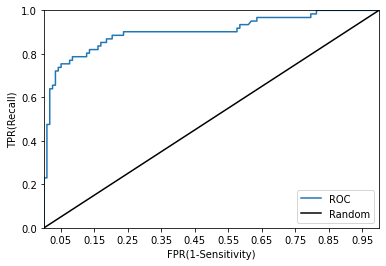

In [21]:
def roc_curve_plot(y_test, pred_proba_c1):
  #임계값에 따른 FPR, TPR 값을 반환받음
  fprs, tprs, thresholds = roc_curve(y_test, pred_proba_c1)
  #ROC 곡선을 그래프로 그림
  plt.plot(fprs,tprs,label='ROC')
  #가운데 대각선 직선을 그림
  plt.plot([0,1],[0,1],'k-',label='Random')

  #FPR X축의 Scale을 0.1 단위로 변경, X, Y축 명 설정 등
  start, end=plt.xlim()
  plt.xticks(np.round(np.arange(start,end,0.1),2))
  plt.xlim(0,1); plt.ylim(0,1)
  plt.xlabel('FPR(1-Sensitivity)'); plt.ylabel('TPR(Recall)')
  plt.legend()

roc_curve_plot(y_test, pred_proba[:,1])

ROC 곡선 자체는 FPR과 TPR의 변화 값을 보는 데 이용하며 분류의 성능 지표로 사용되는 것은 ROC 곡선 면적에 기반한 AUC 값이다. AUC 값은 1에 가까울수록 좋다. FPR이 작은 상태에서 얼마나 큰 TPR을 얻을 수 있는지가 AUC 수치를 키우는 관건이다. 가운데 대각선 직선은 AUC가 0.5이므로 보통의 분류는 0.5 이상의 AUC 값을 갖는다.

In [23]:
def get_clf_eval(y_test,pred=None,pred_proba=None):
  confusion=confusion_matrix(y_test,pred)
  accuracy=accuracy_score(y_test,pred)
  precision=precision_score(y_test,pred)
  recall=recall_score(y_test,pred)
  f1=f1_score(y_test,pred)
  #ROC-AUC 추가
  roc_auc = roc_auc_score(y_test, pred_proba)
  print('오차 행렬')
  print(confusion)
  #ROC-AUC print 추가
  print('정확도: {0:.4f}, 정밀도: {1:.4f}, 재현율: {2:.4f},\F1: {3:.4f}, AUC:{4:.4f}'.format(accuracy, precision, recall, f1, roc_auc))